In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def BSM_exact(S0, sigma, T, r, K):
    d_plus = norm.cdf((np.log(S0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))) 
    d_minus = norm.cdf((np.log(S0 / K) + (r - (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T)))
    return S0 * d_plus - np.exp(-r * T) * K * d_minus

In [3]:
def sweepMethod(b_vector, alpha, beta, gamma):
  A_coeff, B_coeff, solution = np.zeros(len(b_vector)), np.zeros(len(b_vector)), np.zeros(len(b_vector))
  A_coeff[1] = - beta[0] / alpha[0]
  B_coeff[1] = b_vector[0] / alpha[0]
  
  for i in range(1, len(b_vector)-1):
    A_coeff[i+1] = - (beta[i] / gamma[i]) / (A_coeff[i] + alpha[i] / gamma[i])
    B_coeff[i+1] = - (B_coeff[i] - (b_vector[i] / gamma[i])) / (A_coeff[i] + alpha[i] / gamma[i])
  
  solution[-1] = - (B_coeff[-1] - (b_vector[-1] / gamma[i])) / (A_coeff[-1] + alpha[i] / gamma[i])
  for i in range(len(b_vector)-1, 0, -1):
    solution[i-1] = solution[i] * A_coeff[i] + B_coeff[i]
  
  return solution
  
def differenceScheme(K, T, r, sigma, x_count, t_count, x_border, t_border, varying_volatility=False, sheme="explicit"):  
  ''' u_t - sigma_varying^2 / sigma^2 * S * (u_x + u_xx) - 2 * r / sigma^2 u_x = 0 '''

  x_grid = np.linspace(np.log(x_border[0] / K), np.log(x_border[1] / K), x_count)
  t_grid = np.linspace(sigma**2 / 2 * (T - t_border[1]), sigma**2 / 2 * (T - t_border[0]), t_count)
  tau = t_grid[1] - t_grid[0]
  h = x_grid[1] - x_grid[0]
  #print(f"tau < h^2/2  {tau < h**2/2}")
  coeff = 2 * r / sigma**2

  u = np.zeros((x_count, t_count))

  # boundary conditions
  u[0, :] = 0  # x = - inf
  u[1:-1, 0] = np.maximum(np.zeros(x_count-2), 1 - np.exp(-x_grid[1:-1]))
  u[-1, :] = 1 - np.exp(- coeff * t_grid - x_grid[-1]) # x -> inf

  # difference scheme
  if sheme == "explicit":
    sig = 1
    for t in range(0, t_count-1):
      for x in range(1, x_count-1):
        u[x, t+1] = (u[x, t] 
                     + (sig + coeff) * tau / h * (u[x+1, t] - u[x, t]) 
                     + sig * tau / h**2 * (u[x+1, t] - 2 * u[x, t] + u[x-1, t]))
  
  elif sheme == "implicit":
    for t in range(t_count-1):

      # varying volatility
      if varying_volatility == False:
        sig = np.ones(x_count-2)
      else:
        sig = np.power(np.random.normal(0, 0.2, x_count-2), 2) / sigma**2

      alpha = h**2 + sig * 2 * tau + (sig + coeff) * h * tau
      beta = - tau * sig - tau * (sig + coeff) * h
      gamma = - tau * sig

      b = np.zeros(x_count-2)
      b[0] = u[1, t] * h**2 - gamma[0] * u[0, t+1]
      b[-1] = u[-2, t] * h**2 - beta[-1] * u[-1, t+1]
      b[1:-1] = u[2:-2, t] * h**2
      u[1:-1, t+1] = sweepMethod(b, alpha, beta, gamma)

  s = np.exp(x_grid) * K
  v = s * u[:, -1] 
  return s, v

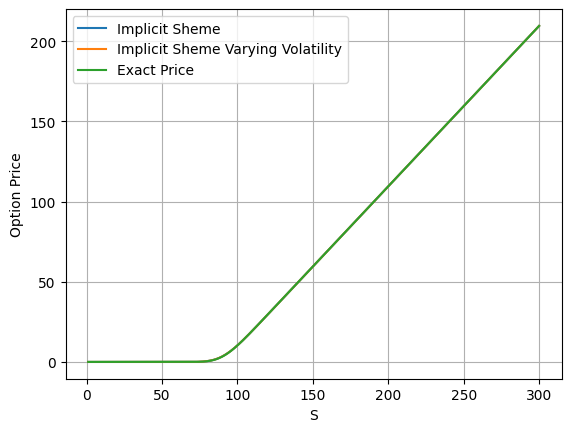

In [6]:
K, T, r, sigma = 100, 1, 0.1, 0.1
x_count, t_count = 800, 200
x_border, t_border = [1, 300], [0, T]

#S_values, explicit_sheme = differenceScheme(K, T, r, sigma, x_count, t_count, x_border, t_border)
S_values, implicit_sheme = differenceScheme(K, T, r, sigma, x_count, t_count, x_border, t_border, sheme="implicit")
S_values, implicit_sheme_varVol = differenceScheme(K, T, r, sigma, x_count, t_count, x_border, t_border, varying_volatility=False, sheme="implicit")
exact_bsm = [BSM_exact(s, sigma, T, r, K) for s in S_values]

#plt.plot(S_values, explicit_sheme, label="Explicit Sheme")
plt.plot(S_values, implicit_sheme, label="Implicit Sheme")
plt.plot(S_values, implicit_sheme_varVol, label="Implicit Sheme Varying Volatility")
plt.plot(S_values, exact_bsm, label="Exact Price")
plt.grid()
plt.legend()
plt.xlabel('S')
plt.ylabel('Option Price')
plt.show()

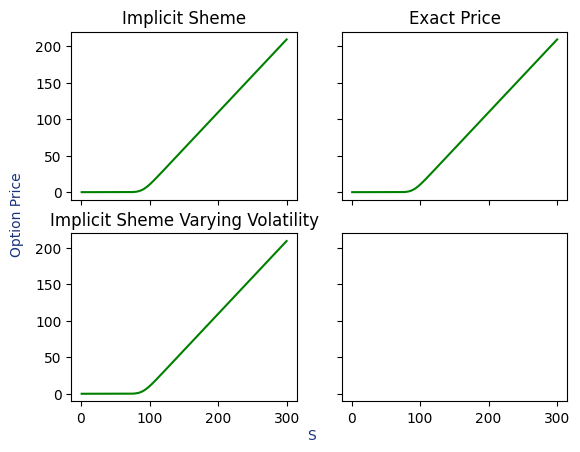

In [7]:
titles = ['Implicit Sheme', 'Exact Price', 'Implicit Sheme Varying Volatility']
solutions = [implicit_sheme, exact_bsm, implicit_sheme_varVol]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for ax, solution, title in zip(axs.flat, solutions, titles):
  ax.set_title(f'{title}')
  ax.plot(S_values, solution, color='green')

fig.text(0.5, 0.04, 'S', ha='center', va='center', color=(0.1, 0.2, 0.5))
fig.text(0.04, 0.5, 'Option Price', ha='center', va='center', rotation='vertical', color=(0.1, 0.2, 0.5))

plt.show()